# Modeling the incidence rate using the factors

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import sys
import seaborn as sns
import matplotlib.pyplot as plt

from tueplots import bundles
from tueplots.constants.color import rgb

sys.path.insert(0, str(Path.cwd().parent))
from src.utils import *

%load_ext autoreload

In [3]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Preparing the Data: 

In [4]:
DATA_FOLDER = "../data/final/"
OUTPUT_FOLDER = "output/"
ihd_df = pd.read_csv(DATA_FOLDER + "gbd_IschemicHeartDisease_DeathsIncidence.csv")
ihd_df.rename(columns={'year': 'Year'}, inplace=True)
ihd_df = ihd_df[ihd_df['measure_name'] == 'Deaths']
ihd_df['Country Code'] = ihd_df['location_name'].apply(get_iso3_gbd)
ihd_df.head()

,measure_name,location_name,cause_name,Year,Value,upper,lower,Country Code
0,Deaths,Greece,Ischemic heart disease,1990,198.963673,206.809839,187.732342,GRC
1,Deaths,Lesotho,Ischemic heart disease,1990,38.577482,47.023134,29.860005,LSO
2,Deaths,Djibouti,Ischemic heart disease,1990,19.784015,25.606502,15.357142,DJI
3,Deaths,Global,Ischemic heart disease,1990,106.468267,110.197494,101.034486,GLB
4,Deaths,Chile,Ischemic heart disease,1990,82.872330,85.753086,78.615036,CHL


In [5]:
fat_df = pd.read_csv(DATA_FOLDER + "daily_per_capita_fat_supply_final.csv")
fat_df = fat_df[(fat_df['Year'] >= 1990) & (fat_df['Year'] <= 2019)]
fat_df.head()

,Country Name,Country Code,Series Name,Year,Value
29,Afghanistan,AFG,Fat consumption per day per capita (grams),1990,53.089370
30,Afghanistan,AFG,Fat consumption per day per capita (grams),1991,48.264060
31,Afghanistan,AFG,Fat consumption per day per capita (grams),1992,43.655660
32,Afghanistan,AFG,Fat consumption per day per capita (grams),1993,35.846720
33,Afghanistan,AFG,Fat consumption per day per capita (grams),1994,34.003414


In [6]:
alcohol_df = pd.read_csv("../data/raw/alcohol_germany.csv")
alcohol_df = alcohol_df[(alcohol_df["TIME"] >= 1990) & (alcohol_df["TIME"] <= 2019)]
alcohol_df.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
30,AUS,ALCOHOL,TOT,LT_CAP15,A,1990,10.6,NaN
31,AUS,ALCOHOL,TOT,LT_CAP15,A,1991,10.1,NaN
32,AUS,ALCOHOL,TOT,LT_CAP15,A,1992,9.9,NaN
33,AUS,ALCOHOL,TOT,LT_CAP15,A,1993,10.2,NaN
34,AUS,ALCOHOL,TOT,LT_CAP15,A,1994,10.0,NaN


In [7]:
healthSpending_df = pd.read_csv("../data/raw/oecd_healthSpending.csv")
healthSpending_df

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,HEALTHEXP,TOT,USD_CAP,A,1971,212.545,NaN
1,AUS,HEALTHEXP,TOT,USD_CAP,A,1972,226.524,NaN
2,AUS,HEALTHEXP,TOT,USD_CAP,A,1973,251.085,NaN
3,AUS,HEALTHEXP,TOT,USD_CAP,A,1974,306.927,NaN
4,AUS,HEALTHEXP,TOT,USD_CAP,A,1975,374.393,NaN
...,...,...,...,...,...,...,...,...
1732,PER,HEALTHEXP,TOT,USD_CAP,A,2016,622.679,NaN
1733,PER,HEALTHEXP,TOT,USD_CAP,A,2017,623.425,NaN
1734,PER,HEALTHEXP,TOT,USD_CAP,A,2018,686.332,NaN
1735,PER,HEALTHEXP,TOT,USD_CAP,A,2019,702.355,NaN


In [8]:
medianAge_df = pd.read_csv("../data/raw/median-age.csv")
medianAge_df = medianAge_df[(medianAge_df['Year'] >= 1990) & (medianAge_df['Year'] <= 2019)]
medianAge_df.drop(columns=['Median age - Sex: all - Age: all - Variant: medium'], inplace=True)
medianAge_df.rename(columns={'Median age - Sex: all - Age: all - Variant: estimates': 'Median Age'}, inplace=True)
medianAge_df

,Entity,Code,Year,Median Age
40,Afghanistan,AFG,1990,15.1
41,Afghanistan,AFG,1991,15.0
42,Afghanistan,AFG,1992,14.9
43,Afghanistan,AFG,1993,14.9
44,Afghanistan,AFG,1994,14.8
...,...,...,...,...
38419,Zimbabwe,ZWE,2015,17.0
38420,Zimbabwe,ZWE,2016,17.2
38421,Zimbabwe,ZWE,2017,17.3
38422,Zimbabwe,ZWE,2018,17.5


In [9]:
print(ihd_df['Country Code'].unique().shape)
print(fat_df['Country Code'].unique().shape)
print(alcohol_df['LOCATION'].unique().shape)
print(healthSpending_df['LOCATION'].unique().shape)

(206,)
(195,)
(49,)
(50,)


# Functions for data merging

In [11]:
def add_alcohol(combined_df):
    alcohol_df_renamed = alcohol_df.rename(columns={'Value': 'Alcohol', "TIME": "Year", "LOCATION": "Country Code"})
    combined_df = combined_df.merge(alcohol_df_renamed[['Alcohol', 'Year', 'Country Code']], on=['Year', 'Country Code'], how='left')
    return combined_df

def add_fat(combined_df):
    fat_df_renamed = fat_df.rename(columns={'Value': 'Fat'})
    combined_df = combined_df.merge(fat_df_renamed[['Fat', 'Year', 'Country Code']], on=['Country Code', 'Year'], how='left')
    return combined_df

def add_healthSpending(combined_df):
    healthSpending_df_renamed = healthSpending_df.rename(columns={'Value': 'Health expenditure', 'TIME': 'Year', 'LOCATION': 'Country Code'})
    combined_df = combined_df.merge(healthSpending_df_renamed[['Health expenditure', 'Year', 'Country Code']], on=['Year', 'Country Code'], how='left')
    return combined_df

def add_medianAge(combined_df):
    medianAge_df_renamed = medianAge_df.rename(columns={'Code': 'Country Code'})
    combined_df = combined_df.merge(medianAge_df_renamed[['Median Age', 'Year', 'Country Code']], on=['Year', 'Country Code'], how='left')
    return combined_df

Top 10 countries with highest average median age from 1990 to 2019

In [12]:
# aveage median age for all countries
avg_median_age = medianAge_df.groupby(['Entity', 'Code']).mean().reset_index()
avg_median_age.drop(columns=['Year'], inplace=True)
# print the sorted list of countries by median age
avg_median_age.sort_values(by=['Median Age'], ascending=False).head(10)


,Entity,Code,Median Age
229,Vatican,VAT,52.980000
138,Monaco,MCO,47.110000
105,Japan,JPN,42.260000
78,Germany,DEU,40.903333
103,Italy,ITA,40.806667
101,Isle of Man,IMN,40.360000
31,Bulgaria,BGR,39.703333
184,San Marino,SMR,39.533333
188,Serbia,SRB,39.410000
71,Finland,FIN,39.300000


In [13]:
combined_df = ihd_df[['Value', 'Year', 'Country Code']].copy()
# combined_df = combined_df[combined_df['Country Code'].isin(country_codes)]
combined_df.rename(columns={"Value":'Death Rate'}, inplace=True)

independents = [add_medianAge, add_fat, add_alcohol, add_healthSpending]
for func in independents:
    combined_df = func(combined_df)  
    combined_df.dropna(inplace=True)
    print(combined_df.shape)
    
combined_df.dropna(inplace=True)
combined_df.drop(columns=['Year', 'Country Code'], inplace=True)
combined_df.reset_index(drop=True, inplace=True)
combined_df

(6120, 4)
(5031, 5)
(1424, 6)
(1115, 7)


,Death Rate,Median Age,Fat,Alcohol,Health expenditure
0,198.963673,35.0,136.877180,10.3,773.660
1,366.289575,35.6,125.342590,13.3,589.815
2,91.409508,36.9,82.114555,9.2,1088.959
3,129.563262,34.2,164.796830,15.4,1558.033
4,201.445701,29.0,123.757380,5.1,1575.185
...,...,...,...,...,...
1110,79.037449,32.0,135.499180,9.8,1497.734
1111,167.722435,46.0,151.993730,7.7,3565.324
1112,77.344261,31.5,102.603330,3.3,1529.721
1113,87.300176,30.0,88.557465,4.1,1239.660


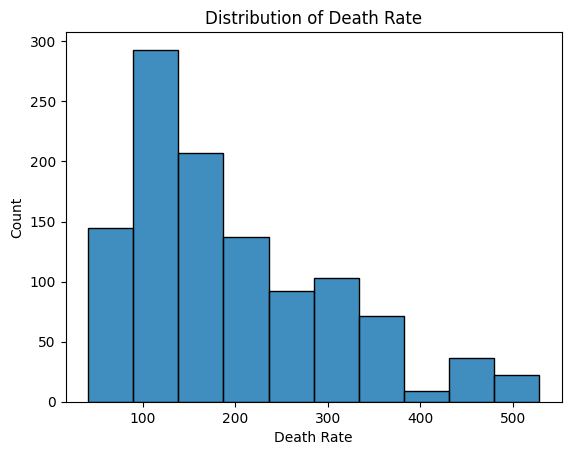

In [14]:
sns.histplot(combined_df['Death Rate'], color=rgb.tue_blue, bins=10)
plt.title('Distribution of Death Rate')
plt.show()

Majority of the values is located in the lower end and around the average.

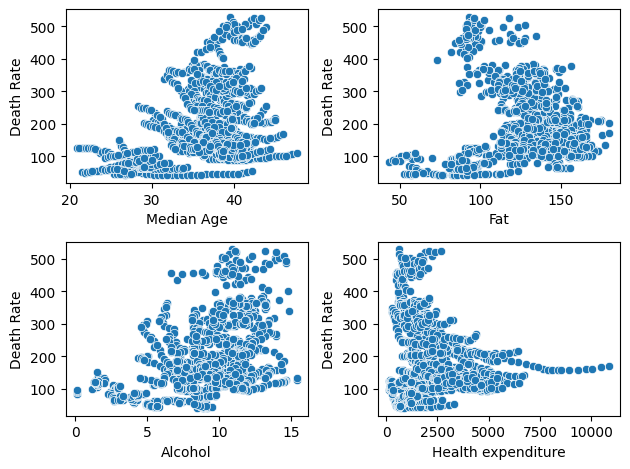

In [15]:

fig, axes = plt.subplots(nrows=2, ncols=2)

i = 0
for col_name in combined_df.columns:
    if col_name == 'Death Rate':
        continue
    row = i // 2
    col= i % 2
    # print(row, col)
    ax = axes[row, col]
    sns.scatterplot(data=combined_df, x=col_name, y='Death Rate', ax=ax)
    # ax.set_title(f'{col_name} vs Incidence Rate')
    i+=1

plt.tight_layout()
plt.show()


It is hard to interpret any clear correlation, could only make guesses about the trends.

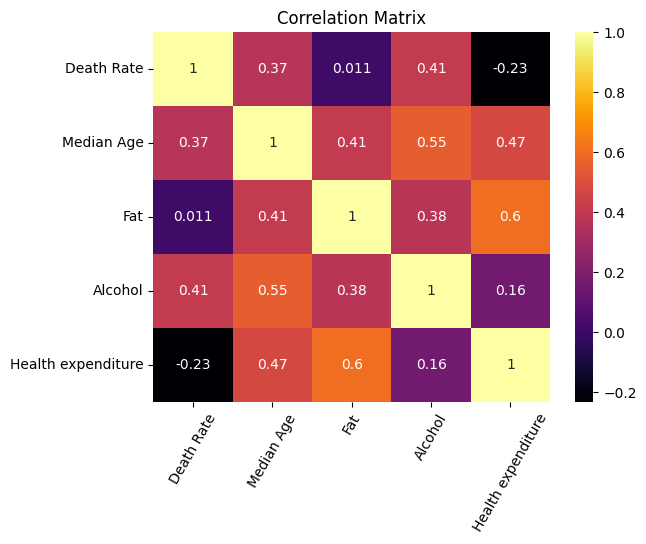

In [16]:

correlation_matrix = combined_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='inferno')
plt.xticks(rotation=60)
plt.title('Correlation Matrix')
plt.show()

Correlation matrix doesn't tell much because the relationship isn't linear, which we will also see when using the linear regression model.

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Prepare the data for modeling
X = combined_df.drop('Death Rate', axis=1)  # independent variables
y = combined_df['Death Rate']  # dependent variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse}')
print(f'R²: {r2}')


MSE: 8034.414383684875
R²: 0.38578312152674665


In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Prepare the data for modeling
X = combined_df.drop('Death Rate', axis=1)  # independent variables
y = combined_df['Death Rate']  # dependent variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with preprocessing and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])

# Define a grid of hyperparameters to search
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20, 30],
    # Add other parameters here
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Predict and evaluate using the best model
rf_pred = best_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

# Output results
print(f'Best Random Forest MSE: {rf_mse}')
print(f'Best Random Forest R²: {rf_r2}')


Best Random Forest MSE: 2367.480839967097
Best Random Forest R²: 0.8190102449379887


Much better results with random forests. $R^2$ value indicates that nearly 82% of the variation in the output can be explained by the model.

In [19]:
# Feature importances
importances = best_model.named_steps['rf'].feature_importances_
feature_names = X_train.columns
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

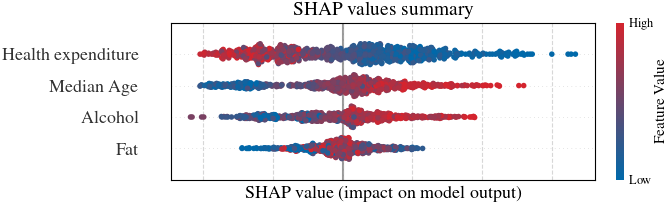

In [24]:
import shap
from tueplots import figsizes
from shap.plots import beeswarm
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

blue = rgb.tue_blue
red = rgb.tue_red
# make red a bit lighter, but not towards pink, less blue
red = (red[0]*1.5, red[1] * 0.8, red[2] * 0.8)
# Create a colormap
cmap = LinearSegmentedColormap.from_list('blue_to_red', [blue, red])


plt.rcParams.update(bundles.icml2022(column="full", ncols=1, nrows=2))
plt.figure()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

# Assuming best_model is your trained RandomForestRegressor from GridSearchCV
explainer = shap.TreeExplainer(best_model.named_steps['rf'])
shap_values = explainer(X_train_scaled)

beeswarm(shap_values, show=False, plot_size = figsizes.icml2022_full()['figure.figsize'], color_bar=False)

# ax.set_title('SHAP values summary')
# Formatting the plot
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(cmap)
num_features = X_train_scaled.shape[1]
feature_order = np.argsort(np.sum(np.abs(explainer.shap_values(X_train_scaled)), axis=0))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False  # labels along the bottom edge are off
)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['left'].set_visible(True)
plt.yticks([])
plt.yticks(range(num_features))
plt.title('SHAP values summary', fontsize=14)
plt.gca().set_xlabel('SHAP value (impact on model output)')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
       
m = cm.ScalarMappable(cmap=cmap)
m.set_array([0, 1])
cb = plt.colorbar(m, ax=plt.gca(), ticks=[0, 1], aspect=20)
cb.set_ticklabels(['Low', 'High'], fontsize=9)
cb.set_label('Feature Value', labelpad=0, fontsize=11)
cb.ax.tick_params(length=0)
cb.set_alpha(1)
cb.outline.set_visible(False)
plt.show()

